# **Import libraries**

In [1]:
# !pip install reparo

In [2]:
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from reparo import KNNImputer
from sklearn.impute import SimpleImputer
%matplotlib inline
import seaborn as sns

In [3]:
def draw_silhouette_plot(X, clusterer, n_clusters, ax):
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    ax.set_xlim([-1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax.set_yticks([])
    ax.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    y_lower = 10
    for i in range(n_clusters):
        ith_values = sample_silhouette_values[cluster_labels == i]
        ith_values.sort()
        size_cluster_i = ith_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_title(f"Silhouette plot for n_clusters = {n_clusters}")

# **Import Dataset**

[Chosen Dataset](https://www.kaggle.com/datasets/kunalgupta2616/hackerearth-customer-segmentation-hackathon)

In [4]:
df_train = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "kunalgupta2616/hackerearth-customer-segmentation-hackathon",
  'avhacklive/Train.csv'
)
df_test = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "kunalgupta2616/hackerearth-customer-segmentation-hackathon",
  'avhacklive/Test.csv'
)
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

Using Colab cache for faster access to the 'hackerearth-customer-segmentation-hackathon' dataset.
Using Colab cache for faster access to the 'hackerearth-customer-segmentation-hackathon' dataset.


# **Analyse Dataset**

In [5]:
df.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0.0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0.0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0.0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0.0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0.0


We won't need id -> drop it.

In [6]:
df.drop('id', axis=1, inplace=True)

In [7]:
pd.DataFrame({
    'unique': df.nunique(),
    'nan': df.isna().sum(),
    'dtype': df.dtypes
})

,unique,nan,dtype
customer_age,79,889,float64
job_type,12,0,object
marital,3,231,object
education,4,0,object
default,2,0,object
balance,7622,580,float64
housing_loan,2,0,object
personal_loan,2,223,object
communication_type,3,0,object
day_of_month,31,0,int64


We will have troubles with missing values.

For days_since_prev_campaign I'll replace missing values with 0 and others with 1, because now that column will mean 1 if we know something about their previous campaign and 0 overwise. I did it because I have too many missing values(60%) and I wasn't sure if I would use something like KNNImputer or SimpleImputeer it'll give something informative.

For months I'll map the values(they have some sort of relationship).

yes/no => 1/0

And I'll use dummies for some of the cols.

In [8]:
df['days_since_prev_campaign_contact'] = df['days_since_prev_campaign_contact'].isna().map({True: 0, False: 1})

In [9]:
months = {
    'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5,
    'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11
}

df['month'] = df['month'].map(months)

In [10]:
outcomes = {'unknown': 0, 'failure': 0, 'other': 0.5, 'success': 1}

df['prev_campaign_outcome'] = df['prev_campaign_outcome'].map(outcomes)

In [11]:
yes_no = {'no': 0, 'yes': 1}

df['personal_loan'] = df['personal_loan'].map(yes_no)
df['housing_loan'] = df['housing_loan'].map(yes_no)
df['default'] = df['default'].map(yes_no)

In [12]:
education = {'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0}

df['education'] = df['education'].map(education)

In [14]:
imputer = SimpleImputer(strategy='most_frequent')

df[['marital']] = imputer.fit_transform(df[['marital']])

In [15]:
dum_cols = ['marital', 'communication_type', 'job_type']

df = pd.get_dummies(df, columns=dum_cols)

In [16]:
df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)

As I'll be using clustering methods, I'll replace missing values in all other features using KNNImputer

In [17]:
knnimputer = KNNImputer()

df = pd.DataFrame(
  knnimputer.fit_transform(df.values),
  columns=df.columns,
  index=df.index
)

In [18]:
std_scaler = StandardScaler()

df[['balance','customer_age']] = std_scaler.fit_transform(df[['balance','customer_age']])

# **GMM**

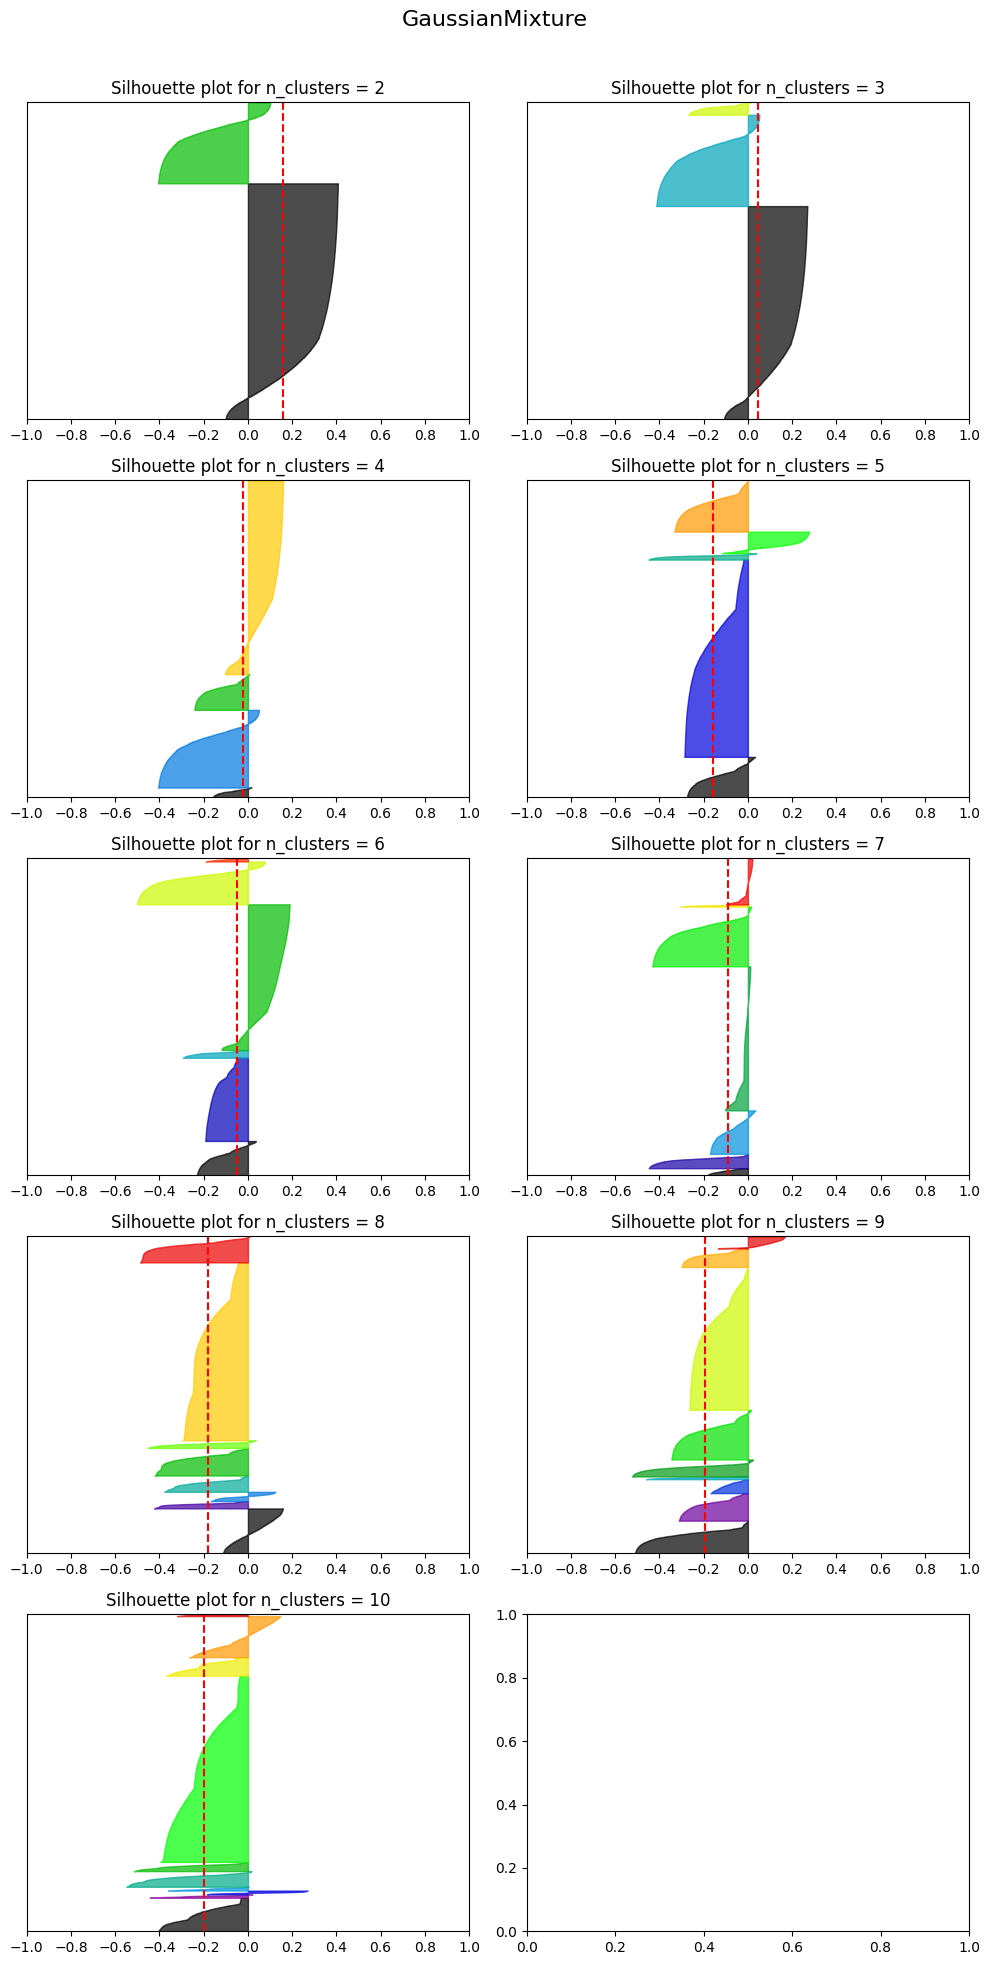

In [19]:
n_components = 10

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
fig.suptitle('GaussianMixture', fontsize=16)

idx = 0
for i in range(2, n_components + 1):
    draw_silhouette_plot(df, GaussianMixture(n_components=i, random_state=42), i, axs[idx // 2][idx % 2])
    idx += 1

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

By sihlouette score, everything is bad(really bad, negative).

2-3 clusters, even though have the best performance, they aren't informative.

So, I'll take 4 - the clusters ar pretty large(no 'noise') and the score is close to 0(bad, but we need to pick the lesser of two evils).

# **KMeans**

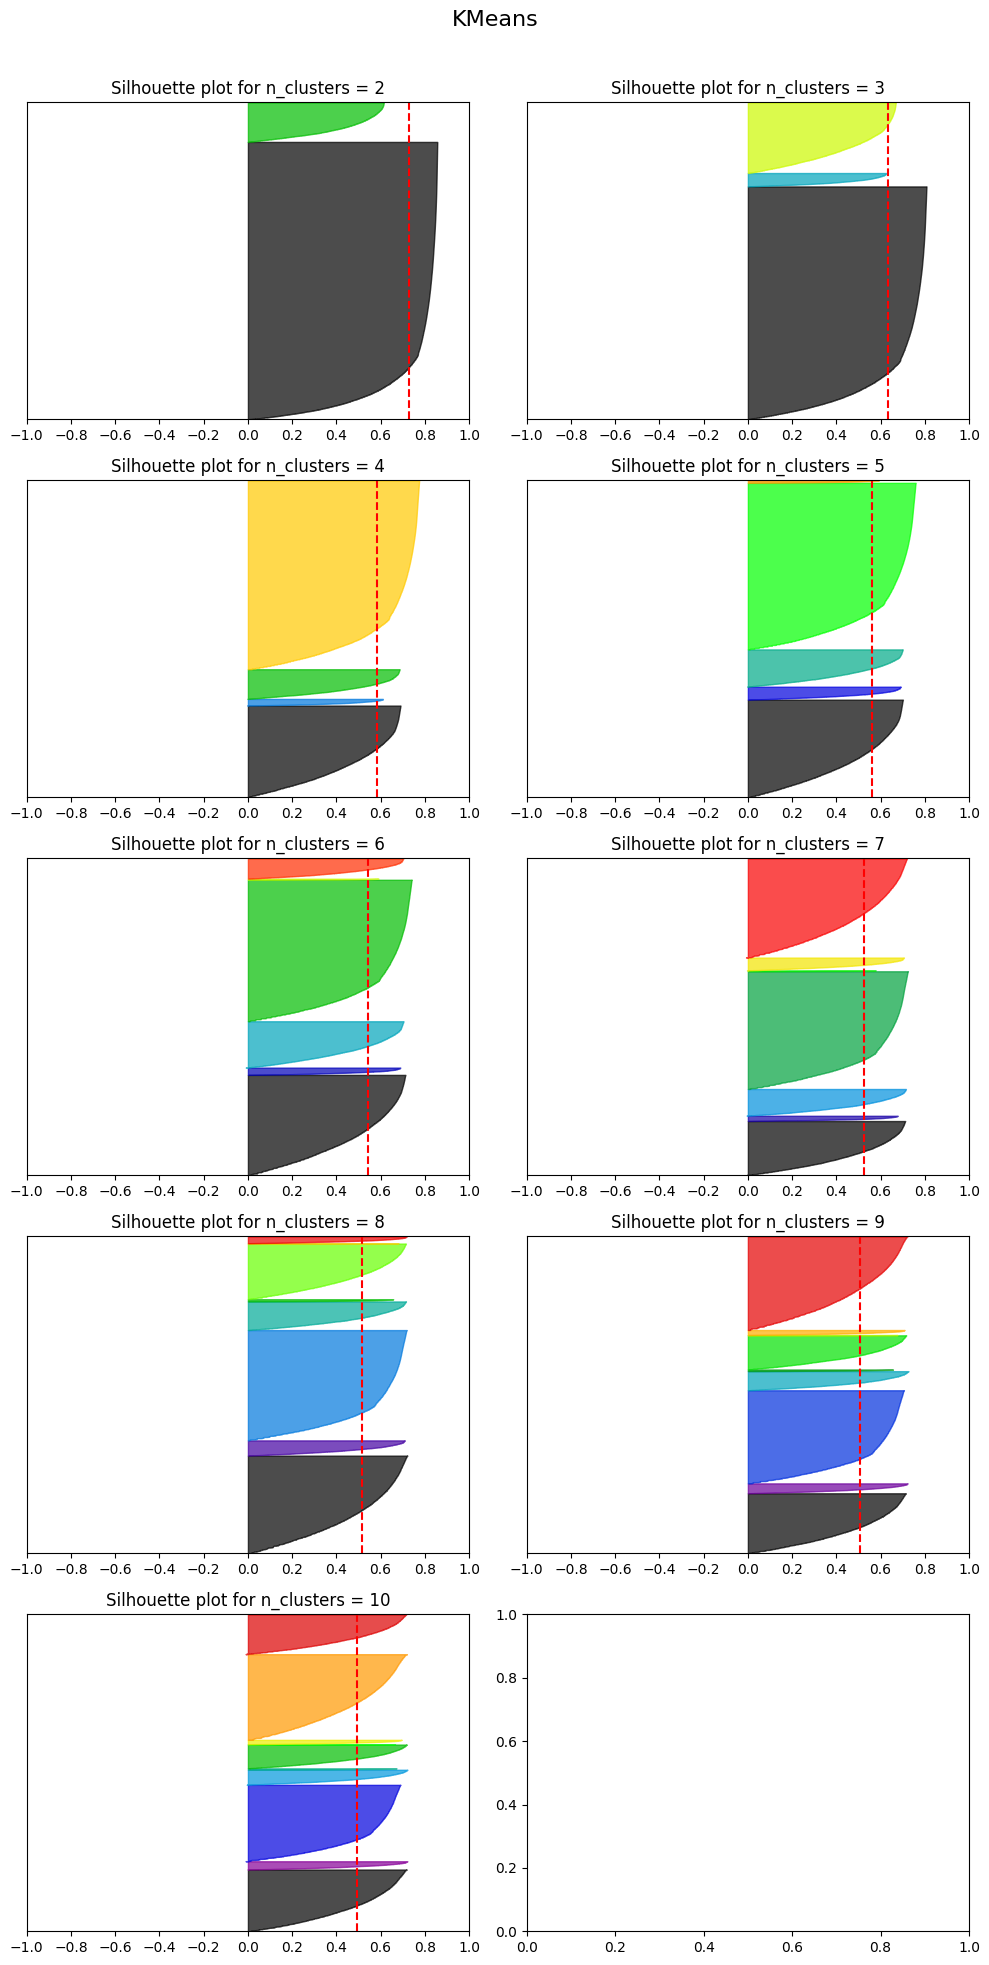

In [20]:
n_clusters = 10

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
fig.suptitle('KMeans', fontsize=16)

idx = 0
for i in range(2, n_clusters + 1):
    draw_silhouette_plot(df, KMeans(n_clusters=i, random_state=42), i, axs[idx // 2][idx % 2])
    idx += 1

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The top result is achieved by 2 clusters. However, as we want to make clusters, it won't be quite useful. 3 is also overperforming the rest, but after it the accuracy starts to decline slowly.

There is no big difference between 4-7 clusters, but I'll prefer a plot with the least amount of really small clusters. So, I'll take also 4 as for GMM, as there are more tiny clusters formed by others that it would be difficult to analyze it.

# **Clustering**

*(I'll use the transpose of the table because I don't see all the features overwise)*

In [21]:
pd.options.display.float_format = '{:,.6f}'.format

## GMM

In [22]:
scaled_cols = ['balance', 'customer_age']

gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(df)

cluster_means = gmm.means_.copy()

scaled_idx = [df.columns.get_loc(c) for c in scaled_cols]
cluster_means[:, scaled_idx] = std_scaler.inverse_transform(cluster_means[:, scaled_idx])

centers_df = pd.DataFrame(
  data=cluster_means,
  index=[f'GMM_K{i}' for i in range(1, cluster_means.shape[0]+1)],
  columns=df.columns
)

centers_df.T

,GMM_K1,GMM_K2,GMM_K3,GMM_K4
customer_age,31.784563,39.928107,49.835038,39.344940
education,1.715613,2.140247,1.930457,2.069514
default,0.086763,0.000000,0.026202,0.020344
balance,"1,337.266834","1,778.698311","1,709.843048","1,128.462975"
housing_loan,0.268679,0.551551,0.376281,0.604724
personal_loan,0.045250,0.139210,0.154424,0.176212
day_of_month,14.809431,15.011949,15.551418,16.220985
month,4.936712,5.069513,5.213160,5.172509
last_contact_duration,251.530059,332.870562,277.362768,224.148909
num_contacts_in_campaign,2.539329,2.408591,2.501107,2.967004


**1. Person:**
- aged ~32(quite young), with secondary education, single student
- most probably not defaulted(even though there is a higher probability than for others)
- with ~1.340 balance
- no housing/personal loan
- day_of_month 15, month - 5(june), last_contact_duration ~252s=~4min
- with 3 contacts in campaign, but with no previous contact(? of 2 people)
- no subscription on deposit
- communicate through cellular

Short: A mature single student around 30, with mean balance, and with no loans, who usually spends around 4 mins on contact.

**2. Person:**
- aged ~40 years, with secondary education, married, in management
- no default in the past, with the highest balance 1.780
- with housing loan, but no personal loan
- day_of_month 15, month - 5(june), last_contact_duration ~333s=~6min
- with 2 contacts in the campaign, with previous contact of 2 people
- no subscription on deposit
- communicate through cellular

Short: A mature married management worker with the highest balance, and with house loan, who usually spends around 6 mins on contact, and has a previous contact.

**3. Person:**
- the eldest group ~50 years, with secondary education, married, retired
- no default in the past, with balance of 1.710
- no housing/personal loan
- day_of_month 16, month - 5(june), last_contact_duration ~277s=~5min
- with 2-3 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

Short: A pretty old, retired, married person, with a higher than mean balance, and with no loans, who usually spends around 5 mins on contact.

**4. Person:**
- ~39 years, with secondary education, married, blue-collar
- no default in the past, with balance of 1.130
- has housing loan, but no personal loan
- day_of_month 16, month - 5(june), last_contact_duration ~224s=~3-4min
- with 3 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular(or unknown)

Short: A mature married blue-collar, with the smallest balance, with a house loan, who usually spends around 3-4 mins on contact.

All in all, the main difference between these clusters are the job type, balance and (main) age group.

## KMeans

In [26]:
kmeans = KMeans(n_clusters=4, random_state=42)

kmeans.fit(df)

centers = kmeans.cluster_centers_.copy()

centers[:, [df.columns.get_loc(c) for c in scaled_cols]] = std_scaler.inverse_transform(
    centers[:, [df.columns.get_loc(c) for c in scaled_cols]]
)

centers_df = pd.DataFrame(
    data=centers,
    index=[f'K{i}' for i in range(1, centers.shape[0]+1)],
    columns=df.columns
)

centers_df.T

,K1,K2,K3,K4
customer_age,40.123686,40.345052,40.380710,40.599884
education,2.052221,2.111229,2.058325,2.063105
default,0.017764,0.009534,0.017168,0.018587
balance,"1,398.048593","1,598.582183","1,455.467997","1,317.428813"
housing_loan,0.554135,0.576271,0.566557,0.554257
personal_loan,0.154562,0.155953,0.150821,0.165426
day_of_month,15.237213,15.276483,15.817733,16.098980
month,5.028254,5.202331,5.134995,5.200556
last_contact_duration,326.299681,"1,379.201271",689.794993,116.896291
num_contacts_in_campaign,2.347800,2.766953,2.484330,3.010918


**1. Person:**
- 40 years, secondary education, blue-collar or management
- no default, with housing loan, without personal loan
- balance of 1.400
- day_of_month 15, month - 5(june), last_contact_duration ~326=~5-6min
- with 2 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

Short: A person with a shorter than mean contact.

**2. Person:**
- 40 years, secondary education, blue-collar or management
- no default, with housing loan, without personal loan
- balance of 1.600
- day_of_month 15, month - 5(june), last_contact_duration ~1.379s=~23min
- with 3 contacts in the campaign, but with no previous contact
- probably has a subscription on deposit
- communicate through cellular

Short: A person with the longest contact.

**3. Person:**
- 40 years, secondary education, blue-collar or management
- no default, with housing loan, without personal loan
- balance of 1.450
- day_of_month 16, month - 5(june), last_contact_duration ~689s=~11-12min
- with 2-3 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

Short: A person with a mean contact.

**4. Person:**
- 41 years, secondary education, management or blue-collar
- no default, with housing loan, without personal loan
- balance of 1.320
- day_of_month 16, month - 5(june), last_contact_duration ~116s=~2min
- with 3 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

Short: A person with the shortest contact.

On the whole, these clusters differ by the duration of the last contact, which this model has found important.

GMM, in comparison with KMeans, have captured more various clusters(most probably thanks to its elliptical shapes due to probabilistic approach).

On the other hand, KMeans has mostly focused on one feature - contact time(maybe other features were difficult to capture because of the spherical).

## Some sort of thinking

Why most of the features are almost the same? I suppose they are irrelevant, the job type, for example, I suppose is the most numerous(by the results below I suppose it is so), same goes with cellular communication type and all others.

In [30]:
df[scaled_cols] = std_scaler.inverse_transform(df[scaled_cols])

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_age,"45,211.000000",40.436392,10.661158,18.000000,32.000000,39.000000,48.000000,97.000000
education,"45,211.000000",2.060516,0.778704,0.000000,2.000000,2.000000,3.000000,3.000000
default,"45,211.000000",0.018027,0.133049,0.000000,0.000000,0.000000,0.000000,1.000000
balance,"45,211.000000","1,359.570011","2,998.323014","-8,020.000000",74.500000,456.000000,"1,433.000000","102,128.000000"
housing_loan,"45,211.000000",0.555838,0.496878,0.000000,0.000000,1.000000,1.000000,1.000000
personal_loan,"45,211.000000",0.160716,0.366318,0.000000,0.000000,0.000000,0.000000,1.000000
day_of_month,"45,211.000000",15.806419,8.322476,1.000000,8.000000,16.000000,21.000000,31.000000
month,"45,211.000000",5.144655,2.408034,0.000000,4.000000,5.000000,7.000000,11.000000
last_contact_duration,"45,211.000000",257.622872,256.715600,0.000000,103.000000,181.000000,319.000000,"4,900.000000"
num_contacts_in_campaign,"45,211.000000",2.764746,3.088088,1.000000,1.000000,2.000000,3.000000,63.000000
